# Introduction to pyro
Taken from: https://pyro.ai/examples/intro_long.html

### Terms pyro lingo

#### Variables and Parameters

* Random Variables `pyro.sample`
* Observed Random Variables `pyro.sample`
* Parameters (non-random) variables (e.g. variational parameters) `pyro.param`


#### Example Linear Regression

This is the ruggness in afric example given in stat. rethinking. Note we are first doing non-Bayesian linear regression.

Taken from https://pyro.ai/examples/intro_long.html#Example:-Geography-and-national-income

In [19]:
from pyro.distributions import LogNormal, Categorical, MultivariateNormal, Normal
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [20]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [26]:
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [27]:
df.head()

,cont_africa,rugged,rgdppc_2000
2,1,0.858,0.700082
4,0,3.427,0.744884
7,0,0.769,0.831120
8,0,0.775,0.807126
9,0,2.688,0.719371


In [28]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

In [32]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(())) #We initialize with random
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

#render_parameters=True not working in the current installation
#pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp))

### Sampling or posterior evaluation

Calling the simple_model without an argument, finally calls

```
 return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
```

If `log_gdp=None` than a sample is drawn. Therefore, you get different results for the two calls below

In [33]:
simple_model(is_cont_africa, ruggedness)[0:3],simple_model(is_cont_africa, ruggedness)[0:3]

(tensor([ 0.3233,  1.6264, -0.6370], grad_fn=<SliceBackward0>),
 tensor([0.0593, 4.2755, 0.9525], grad_fn=<SliceBackward0>))

In [34]:
simple_model(is_cont_africa, ruggedness, log_gdp)[0:3],simple_model(is_cont_africa, ruggedness, log_gdp)[0:3] #Calcluates the posterior

(tensor([0.7001, 0.7449, 0.8311]), tensor([0.7001, 0.7449, 0.8311]))

### Persistence of parameters

The parameters are values that need to be updated by an external optimization or so. Therefore they are stored in a central place and
`pyro.param` values persist across model calls, unless the parameter store is updated by an optimization algorithm or cleared via `pyro.clear_param_store()`.


In [35]:
pyro.get_param_store().get_param('bA'),pyro.get_param_store().get_param('bA')

(tensor(-0.1517, requires_grad=True), tensor(-0.1517, requires_grad=True))

### The plate statement

Think of plates as for loops. But internaly pyro uses thinks like broadcasting happens for parallel excecution and the stuff is fast as hell.

### Going Bayesian
Just replace the parameters variables (`pyro.sample`)

In [46]:
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

#pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

In [47]:
simple_model(is_cont_africa, ruggedness)[0:3],simple_model(is_cont_africa, ruggedness)[0:3]

(tensor([-3.8702, -3.3012, -2.7912], grad_fn=<SliceBackward0>),
 tensor([-4.2957, -6.2677, -3.5680], grad_fn=<SliceBackward0>))

In [48]:
simple_model(is_cont_africa, ruggedness, log_gdp)[0:3],simple_model(is_cont_africa, ruggedness, log_gdp)[0:3]

(tensor([0.7001, 0.7449, 0.8311]), tensor([0.7001, 0.7449, 0.8311]))

# Variational Inference and Guides

The variational distribtion has to be defined in a guide. It needs to provide a valid joint probability for all random variables present in the model. The names of the random variables in a guide  need to match.

```
def model():
    pyro.sample("z_1", ...) #<-- z_1
```

The variables
```
def guide():
    z_1_loc = pyro.param('z1_loc', lambda: torch.tensor(0.))
    z_1_scale = pyro.param('z1_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    pyro.sample("z_1", dist.Normal(z_1_loc, z_1_scale) )#<-- z_1
```

The variables are described by one or more variational parameters.

In [49]:
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}

#pyro.render_model(custom_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

#### Inference

In [50]:
%%time
pyro.clear_param_store() #Delete all existing parameters
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, custom_guide, adam, elbo)

losses = []
for step in range(5000):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

ValueError: Expected parameter scale (Tensor of shape (170,)) of distribution Normal(loc: torch.Size([170]), scale: torch.Size([170])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([-0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096], grad_fn=<ExpandBackward0>)
Trace Shapes:      
 Param Sites:      
Sample Sites:      
       a dist     |
        value     |
      bA dist     |
        value     |
      bR dist     |
        value     |
     bAR dist     |
        value     |
   sigma dist     |
        value     |
    data dist     |
        value 170 |

In [51]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

a_loc 0.7820944
a_scale 0.013650103
sigma_loc 0.16775244
weights_loc [-0.1427799  -0.00412611  0.03593678]
weights_scale [0.02179492 0.00997078 0.01552858]


### MCMC Simulations

In [52]:
#### MCMC ####
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=500)
mcmc.run(is_cont_africa, ruggedness, log_gdp)

Sample: 100%|██████████| 1000/1000 [00:10, 99.96it/s, step size=2.47e-01, acc. prob=0.939]


In [53]:
mcmc.diagnostics()

{'a': OrderedDict([('n_eff', tensor(195.4850)), ('r_hat', tensor(1.0025))]),
 'bA': OrderedDict([('n_eff', tensor(155.9514)), ('r_hat', tensor(0.9987))]),
 'bAR': OrderedDict([('n_eff', tensor(191.5359)), ('r_hat', tensor(0.9986))]),
 'bR': OrderedDict([('n_eff', tensor(203.0556)), ('r_hat', tensor(1.0013))]),
 'sigma': OrderedDict([('n_eff', tensor(172.8843)),
              ('r_hat', tensor(0.9980))]),
 'divergences': {'chain 0': []},
 'acceptance rate': {'chain 0': 0.996}}

(9.1784115, 0.13632008)

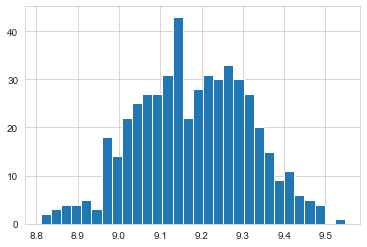

In [17]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
plt.hist(hmc_samples.get('a'), 30);
np.mean(hmc_samples.get('a')), np.std(hmc_samples.get('a'))

### Posterior Predictive Checks

There are convenience functions for the posterior predictive (see also https://pyro.ai/examples/intro_long.html#Example:-posterior-predictive-uncertainty-in-Pyro)

In [18]:
predictive = pyro.infer.Predictive(model, guide=custom_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)

In [19]:
svi_samples["obs"].shape, svi_samples["rugged"]

KeyError: 'rugged'